<a href="https://colab.research.google.com/github/gazzstar/Python/blob/master/doc/notebooks/pyddm_demo_leaky_collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#@title Install Necessary

!pip install scikit-learn
!pip install cython
!pip install pymc
!pip -q install git+https://github.com/mwshinn/PyDDM
!pip install -U git+https://github.com/hddm-devs/hddm
!pip install -U git+https://github.com/hddm-devs/kabuki
!apt-get -qq install -y graphviz && pip install pydot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hddm-devs/hddm to /tmp/pip-req-build-3hqk995p
  Running command git clone -q https://github.com/hddm-devs/hddm /tmp/pip-req-build-3hqk995p
  Running command git submodule update --init --recursive -q
  Using cached statsmodels-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Using cached cloudpickle-2.1.0-py3-none-any.whl (25 kB)
  Using cached pymc-2.3.8-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: PyMC
    Fou

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-2gtkegyh
  Running command git clone -q https://github.com/hddm-devs/kabuki /tmp/pip-req-build-2gtkegyh
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#@title MODULE IMPORTS
!pip install scikit-learn

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle
import cython
import pymc
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pyddm as ddm
import pyddm.plot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
class DriftLeak(ddm.Drift):
    name = "Leaky drift"
    required_parameters = ["drift", "leak"]
    def get_drift(self, x, **kwargs):
        return self.drift - self.leak*x
#@title Run the model GUI
model = ddm.Model(drift=DriftLeak(drift=ddm.Fittable(minval=0, maxval=3, default=.1),
                                  leak=ddm.Fittable(minval=-2, maxval=2, default=1)),  
                  noise=ddm.NoiseConstant(noise=ddm.Fittable(minval=.001, maxval=2, default=.5)),
                  bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=.5, maxval=1.5, default=1),
                                                       tau=ddm.Fittable(minval=.1, maxval=5, default=1)),
                  dx=.01, dt=.01, T_dur=2)
pyddm.plot.model_gui_jupyter(model=model)

Output()

In [6]:
# Metadata
model = 'ddm'
n_samples = 10000

# Config for our current model
hddm.model_config.model_config[model]

{'doc': 'Basic DDM. Meant for use with the LAN extension. nNote that the boundaries here are coded as -a, and a in line with all other models meant for the LAN extension. nTo compare model fits between standard HDDM and HDDMnn when using the DDM model, multiply the boundary (a) parameter by 2. nWe recommend using standard HDDM if you are interested in the basic DDM, but you might want to use this for testing.',
 'params': ['v', 'a', 'z', 't'],
 'params_trans': [0, 0, 1, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001], [3.0, 2.5, 0.9, 2.0]],
 'boundary': [0],
 'params_default': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15}}


{'doc': 'Basic DDM. Meant for use with the LAN extension. nNote that the boundaries here are coded as -a, and a in line with all other models meant for the LAN extension. nTo compare model fits between standard HDDM and HDDMnn when using the DDM model, multiply the boundary (a) parameter by 2. nWe recommend using standard HDDM if you are interested in the basic DDM, but you might want to use this for testing.',
 'params': ['v', 'a', 'z', 't'],
 'params_trans': [0, 0, 1, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001], [3.0, 2.5, 0.9, 2.0]],
 'boundary': [0],
 'params_default': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15}}

In [7]:
#@title Use HDDM to run full DDM
# Stats functionality

import kabuki
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
n_samples = 10000
# HDDM
from hddm.simulators.hddm_dataset_generators import simulator_h_c
data, full_parameter_dict = simulator_h_c(n_subjects = 1,
                                          n_trials_per_subject = n_samples,
                                          model = model,
                                          p_outlier = 0.00,
                                          conditions = None,
                                          depends_on = None,
                                          regression_models = None,
                                          regression_covariates = None,
                                          group_only_regressors = False,
                                          group_only = None,
                                          fixed_at_default = None)

subj_idx(0)


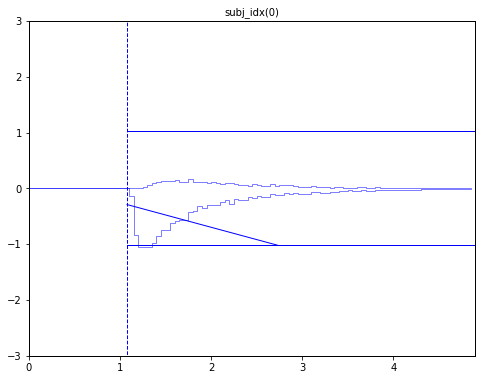

In [10]:
data
hddm.plotting.plot_from_data(df = data,
                             generative_model = model,
                             columns = 1,
                             groupby = ['subj_idx'],
                             figsize = (8, 6),
                             value_range = np.arange(0, 5, 0.1),
                             plot_func = hddm.plotting._plot_func_model,
                             **{'alpha': 1.,
                                'ylim': 3,
                                'add_data_rts': True,
                                'add_data_model': True})
plt.show()

In [15]:
# Metadata
nmcmc = 15000
model = 'angle'
n_samples = 10000
includes = hddm.model_config.model_config[model]['hddm_include']

# Generate some simulatred data
from hddm.simulators.hddm_dataset_generators import simulator_h_c
data, full_parameter_dict = simulator_h_c(n_subjects = 1,
                                          n_trials_per_subject = n_samples,
                                          model = model,
                                          p_outlier = 0.0001,
                                          conditions = None,
                                          depends_on = None,
                                          regression_models = None,
                                          regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                          group_only_regressors = False,
                                          group_only = None,
                                          fixed_at_default = None)

AttributeError: ignored

In [ ]:
hddmnn_model = hddm.HDDMnn(data,
                           informative = False,
                           include = includes,
                           p_outlier = 0.01,
                           w_outlier = 0.1,
                           model = model,)

In [ ]:
# Metadata
nmcmc = 15000
model = 'angle'
n_samples = 10000
includes = hddm.model_config.model_config[model]['hddm_include']

# Generate some simulatred data
from hddm.simulators.hddm_dataset_generators import simulator_h_c
data, full_parameter_dict = simulator_h_c(n_subjects = 1,
                                          n_trials_per_subject = n_samples,
                                          model = model,
                                          p_outlier = 0.0001,
                                          conditions = None,
                                          depends_on = None,
                                          regression_models = None,
                                          regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                          group_only_regressors = False,
                                          group_only = None,
                                          fixed_at_default = None)

hddmnn_model = hddm.HDDMnn(data,
                           informative = False,
                           include = includes,
                           p_outlier = 0.01,
                           w_outlier = 0.1,
                           model = model,)


In [ ]:
data

In [17]:
# Define the HDDM model
hddmnn_model = hddm.HDDMnn(data,
                           informative = False,
                           include = includes,
                           p_outlier = 0.01,
                           w_outlier = 0.1,
                           model = model,)

# Sample
hddmnn_model.sample(nmcmc,
                    burn = 1500)

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
 [-----------------100%-----------------] 15000 of 15000 complete in 665.1 sec

In [ ]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               figsize = (8, 5),
                               columns = 1)

plt.show()

AttributeError: ignored

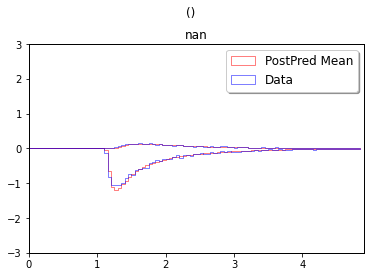

In [20]:
hddm.plotting.plot_posterior_predictive(model = hddmnn_model,
                                        columns = 1,
                                        groupby = ['subj_idx'],
                                        figsize = (6, 4),
                                        value_range = np.arange(0, 5, 0.1),
                                        plot_func = hddm.plotting._plot_func_model,
                                        parameter_recovery_mode = True,
                                        **{'alpha': 0.01,
                                        'ylim': 3,
                                        'samples': 200})
plt.show()

# TAKING A LOOK AT THE POSTERIOR TRACES
hddmnn_model.plot_posteriors(hddm.simulators.model_config[model]['params'])
plt.show()

KeyError: ignored

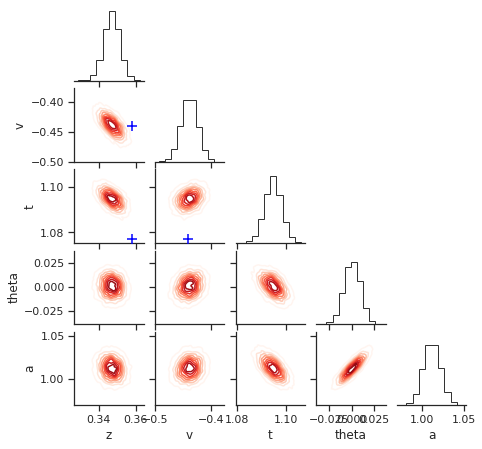

In [21]:
hddm.plotting.plot_posterior_pair(hddmnn_model, save = False,
                                  parameter_recovery_mode = True,
                                  samples = 50000,
                                  figsize = (6, 6))

In [25]:
# Metadata
nmcmc = 50000
model = 'angle'
n_subjects = 30
n_trials_per_subject = 70

data, full_parameter_dict = simulator_h_c(n_subjects = n_subjects,
                                          n_trials_per_subject = 70,
                                          model = 'angle',
                                          p_outlier = 0.001,
                                          conditions = {'c_one': ['low', 'medium', 'high']}, #, 'c_three': ['low', 'medium', 'high']},
                                          depends_on = {'v': ['c_one']}, # 'theta': ['c_two']}, # 'theta': ['c_two']}, #regression_models = None, #
                                          regression_models = None, #regression_covariates = None,
                                          regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                          group_only_regressors = False,
                                          group_only = None,
                                          fixed_at_default = None)

AttributeError: ignored

In [26]:
hddmnn_model.sample(nmcmc, burn = 500)

# Make HDDM Model
hddmnn_model = hddm.HDDMnn(data,
                           model = model,
                           informative = False,
                           include = hddm.simulators.model_config[model]['hddm_include'],
                           p_outlier = 0.0,
                           is_group_model = True,
                           depends_on = {'v': 'c_one'})

hddm.plotting.plot_posterior_predictive(model = hddmnn_model,
                                        columns = 10,
                                        groupby = ['subj_idx'],
                                        figsize = (24, 16),
                                        value_range = np.arange(0, 5, 0.1),
                                        plot_func = hddm.plotting._plot_func_model,
                                        parameter_recovery_mode = True,
                                        **{'alpha': 0.01,
                                        'ylim': 3,
                                        'samples': 200})
plt.show()

 [-----------------100%-----------------] 50000 of 50000 complete in 2212.7 sec

KeyError: ignored

In [ ]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddmnn_model.plot_posteriors(hddm.simulators.model_config[model]['params'])
plt.show()

AttributeError: ignored

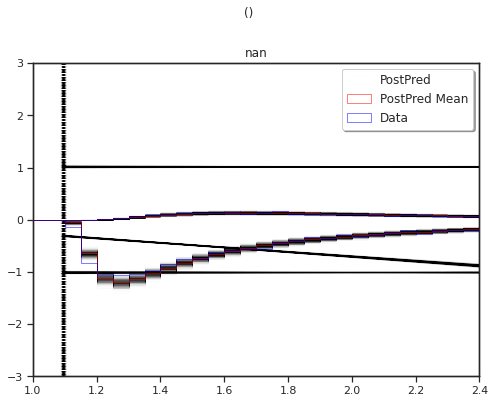

In [28]:
hddm.plotting.plot_posterior_predictive(model = hddmnn_model,
                                        #columns = 6, # groupby = ['subj_idx'],
                                        #figsize = (8, 6),
                                        value_range = np.arange(1, 2.5, 0.1),
                                        plot_func = hddm.plotting._plot_func_model,
                                        parameter_recovery_mode = True,
                                        **{'alpha': 0.01,
                                        #'ylim': 3,
                                        'add_posterior_uncertainty_rts': True,
                                        'add_posterior_uncertainty_model': True,
                                        'samples': 1000})
                                        #'legend_fontsize': 7})
plt.show()

In [ ]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddmnn_model.plot_posteriors(hddm.simulators.model_config[model]['params'])
plt.show()

In [ ]:
hddm.plotting.plot_posterior_pair(hddmnn_model, save = True,
                                  parameter_recovery_mode = True,
                                  samples = 1500,
                                  figsize = (6, 6))

In [ ]:
# estimate convergence
from kabuki.analyze import gelman_rubin

models = []
for i in range(3):
    m = hddm.HDDMrl(data=data)
    m.sample(1500, burn=500,dbname='traces.db',db='pickle')
    models.append(m)

gelman_rubin(models)

In [59]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_bar().encode(
  x=alt.X('Miles_per_Gallon', bin=True),
  y='count()',
  color='Origin'
)

alt.Chart(...)

In [61]:
from vega_datasets import data
stocks = data.stocks()

import altair as alt
alt.Chart(stocks).mark_line().encode(
  x='date:T',
  y='price',
  color='symbol'
).interactive(bind_y=False)

alt.Chart(...)

In [62]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

import altair as alt

interval = alt.selection_interval()

base = alt.Chart(cars).mark_point().encode(
  y='Miles_per_Gallon',
  color=alt.condition(interval, 'Origin', alt.value('lightgray'))
).properties(
  selection=interval
)

base.encode(x='Acceleration') | base.encode(x='Horsepower')

alt.HConcatChart(...)

In [63]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_bar().encode(
  x=alt.X('Miles_per_Gallon', bin=True),
  y='count()',
)

alt.Chart(...)

In [64]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_bar().encode(
  x='mean(Miles_per_Gallon)',
  y='Origin',
  color='Origin'
)

alt.Chart(...)

In [ ]:
import ipywidgets as widgets

slider = widgets.IntSlider(20, min=0, max=100)
slider

In [66]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import altair as alt
import ipywidgets as widgets
from vega_datasets import data

source = data.stocks()

stock_picker = widgets.SelectMultiple(
    options=source.symbol.unique(),
    value=list(source.symbol.unique()),
    description='Symbols')

# The value of symbols will come from the stock_picker.
@widgets.interact(symbols=stock_picker)
def render(symbols):
  selected = source[source.symbol.isin(list(symbols))]

  return alt.Chart(selected).mark_line().encode(
      x='date',
      y='price',
      color='symbol',
      strokeDash='symbol',
  )